In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [127]:
data = pd.read_csv("C:\solar\Solar_Electric_240407.csv")

C:\Users\LL\AppData\Local\Temp\ipykernel_15872\1627145391.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\solar\Solar_Electric_240407.csv")


In [128]:
data = data.drop(columns = ['Reporting Period', 'Legacy Project Number', 'Street Address', 'City', 'Census Tract',
                           'Latitude', 'Longitude', 'Georeference'])
data = data.drop(columns = ['ZIP Code', 'Incorporated Municipality', 'Municipality Type'])
data = data.drop(columns = ['Primary Inverter Manufacturer', 'Primary Inverter Model Number',
       'Total Inverter Quantity', 'Primary PV Module Manufacturer',
       'PV Module Model Number', 'Total PV Module Quantity'])
data = data.drop(columns = ['Sector','Contractor'])

In [129]:
# only one project is in outside of NYS. 

data.loc[data['State'] == 'Ontario']

,Project Number,County,State,NYS Disadvantaged Community Status,Climate and Economic Justice Screening Tool Status,Program Type,Solicitation,Electric Utility,Purchase Type,Date Application Received,...,Inclusive Community Solar Adder,Expanded Solar For All Adder,Brownfield/Landfill Adder,Canopy Adder,Prevailing Wage Adder,Total Nameplate kW DC,Expected KWh Annual Production,Remote Net Metering,Community Distributed Generation,Green Jobs Green New York Participant
8521,0000353614,NaN,Ontario,NaN,NaN,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,10/22/2021,...,0.0,0,0.0,0.0,0.0,6.84,6321.0,NaN,No,No


In [130]:
data = data.drop(columns = ['State'])

### dont run

In [44]:
# how many missing values are in the complete subset

solar_complete = data.loc[data['Project Status'] == 'Complete']

In [66]:
# print(solar_complete['Remote Net Metering'].isna().values.sum())

# the majority come from 'Remote Net Metering', drop it
solar_complete = solar_complete.drop(columns = ['Remote Net Metering'])
# also other useless columns
solar_complete = solar_complete.drop(columns = ['Date Completed', 'Project Status'])
print(solar_complete.isna().values.sum())
solar_complete

14770


In [52]:
# how about pipeline

solar_pipe = data.loc[data['Project Status'] == 'Pipeline']

# solar_pipe.drop(columns = ['Date Completed', 'Remote Net Metering']).isna().values.sum()
# 252

solar_pipe = solar_pipe.drop(columns = ['Date Completed', 'Remote Net Metering'])

In [59]:
solar_pipe.isna().values.sum()

252

### missing values & extract date & get dummies

In [131]:
data = data.drop(columns = ['Project Number', 'Date Completed', 'Remote Net Metering', 'Project Status'])

In [132]:
# populate date variable

# type(data['Date Application Received'].iloc[1])
# str

# EXTRACT YEAR
data['Application Year'] = data['Date Application Received'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y").date().year)

data = data.drop(columns = ['Date Application Received'])

In [133]:
data = data.dropna()

In [134]:
# cate:
cate = ['County', 'NYS Disadvantaged Community Status',
       'Climate and Economic Justice Screening Tool Status', 'Program Type',
       'Solicitation', 'Electric Utility', 'Purchase Type',
       'Application Year',
       'Minority or Women Owned Business Enterprise (MWBE)',
       'Community Distributed Generation',
       'Green Jobs Green New York Participant']

In [135]:
data['Application Year'].apply(lambda x: str(x))

1         2024
2         2023
3         2022
4         2023
5         2023
          ... 
163482    2015
163483    2023
163484    2022
163485    2020
163486    2023
Name: Application Year, Length: 153362, dtype: object

In [137]:
data_dummies = pd.get_dummies(data, columns=cate, dtype=float, drop_first = True)

In [138]:
print(data_dummies.columns)

Index(['Project Cost', 'Total NYSERDA Incentive',
       'Affordable Solar Residential Adder',
       'Affordable Multifamily Housing Incentive', 'Community Adder',
       'Inclusive Community Solar Adder', 'Expanded Solar For All Adder',
       'Brownfield/Landfill Adder', 'Canopy Adder', 'Prevailing Wage Adder',
       ...
       'Application Year_2018', 'Application Year_2019',
       'Application Year_2020', 'Application Year_2021',
       'Application Year_2022', 'Application Year_2023',
       'Application Year_2024',
       'Minority or Women Owned Business Enterprise (MWBE)_Yes',
       'Community Distributed Generation_Yes',
       'Green Jobs Green New York Participant_Yes'],
      dtype='object', length=146)


In [139]:
X_reg = data_dummies.drop(columns = ['Total NYSERDA Incentive'])
y_reg = data_dummies['Total NYSERDA Incentive']

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

### Regression
dependent: 'Total NYSERDA Incentive' <br>
assumption: Additional funding is not am outcome of the amount of funding this project got from NYSERDA. These variables serve as descriptive factors of the projects due to the application requirements

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [143]:
lin = LinearRegression().fit(X_train, y_train)

In [144]:
y_pred_lin = lin.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)

print('mean squared error of linear regression model: ',mse_lin)

# linear regression is not a good idea

mean squared error of linear regression model:  2125587349.2304795


In [ ]:
# also poly can't handle that much data after introducing dummy variables

### try RF

In [145]:
from sklearn.ensemble import RandomForestRegressor

In [150]:
X_train_rf = np.array(X_train)
y_train_rf = np.array(y_train)
X_test_rf = np.array(X_test)
y_test_rf = np.array(y_test)

In [151]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train_rf, y_train_rf)

predictions = rf.predict(X_test_rf)

print('MSE:', round(mean_squared_error(y_test, predictions), 2))

MSE: 1131748509.46


### Hypo 2

In [172]:
data = data.loc[data['Project Cost'] != 0.00]

In [166]:
cols = ['Affordable Solar Residential Adder',
       'Affordable Multifamily Housing Incentive', 'Community Adder',
       'Inclusive Community Solar Adder', 'Expanded Solar For All Adder',
       'Brownfield/Landfill Adder', 'Canopy Adder', 'Prevailing Wage Adder']

data['Additional'] = data[list(cols)].sum(axis=1)

data['cost after additional'] = data['Project Cost'] - data['Additional']
data['cost after funding'] = data['Project Cost'] - data['Total NYSERDA Incentive']

In [178]:
data['coverage by additional'] = data['Additional']/data['Project Cost']
data['coverage by funding'] = data['Total NYSERDA Incentive']/data['Project Cost']

C:\Users\LL\AppData\Local\Temp\ipykernel_15872\598788915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['coverage by additional'] = data['Additional']/data['Project Cost']
C:\Users\LL\AppData\Local\Temp\ipykernel_15872\598788915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['coverage by funding'] = data['Total NYSERDA Incentive']/data['Project Cost']


In [187]:
resi = sum(data['coverage by additional'].loc[data['Program Type'] == 'Residential/Small Commercial'])/len(data['coverage by additional'].loc[data['Program Type'] == 'Residential/Small Commercial'])
compe = sum(data['coverage by additional'].loc[data['Program Type'] == 'Commercial/Industrial (Competitive)'])/len(data['coverage by additional'].loc[data['Program Type'] == 'Commercial/Industrial (Competitive)'])
commer = sum(data['coverage by additional'].loc[data['Program Type'] == 'Commercial/Industrial (MW Block)'])/len(data['coverage by additional'].loc[data['Program Type'] == 'Commercial/Industrial (MW Block)'])

In [214]:
resi_ = sum(data['coverage by funding'].loc[data['Program Type'] == 'Residential/Small Commercial'])/len(data['coverage by funding'].loc[data['Program Type'] == 'Residential/Small Commercial'])
compe_ = sum(data['coverage by funding'].loc[data['Program Type'] == 'Commercial/Industrial (Competitive)'])/len(data['coverage by funding'].loc[data['Program Type'] == 'Commercial/Industrial (Competitive)'])
commer_ = sum(data['coverage by funding'].loc[data['Program Type'] == 'Commercial/Industrial (MW Block)'])/len(data['coverage by funding'].loc[data['Program Type'] == 'Commercial/Industrial (MW Block)'])

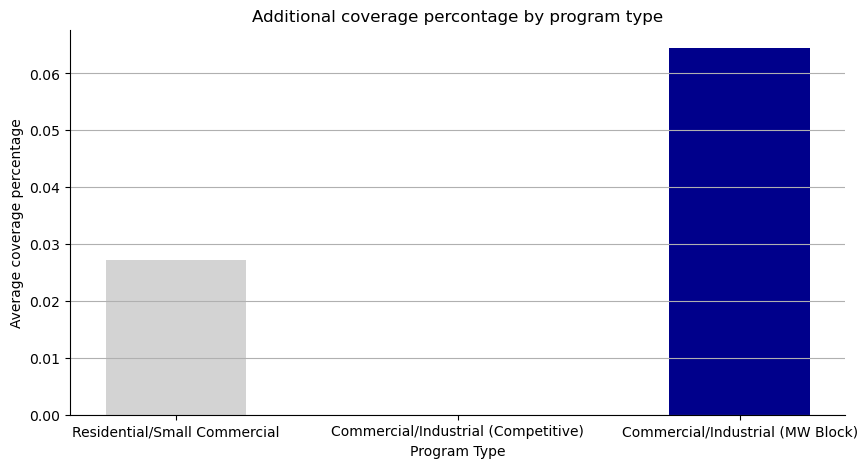

In [215]:
plt.figure(figsize=(10, 5)) 

plt.bar(x=['Residential/Small Commercial', 'Commercial/Industrial (Competitive)', 'Commercial/Industrial (MW Block)'],
        height=[resi, compe, commer], width = .5, color = ['lightgrey', 'black', 'darkblue'])

plt.title("Additional coverage percontage by program type")
plt.xlabel("Program Type")
plt.ylabel("Average coverage percentage")

plt.grid(axis='y')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

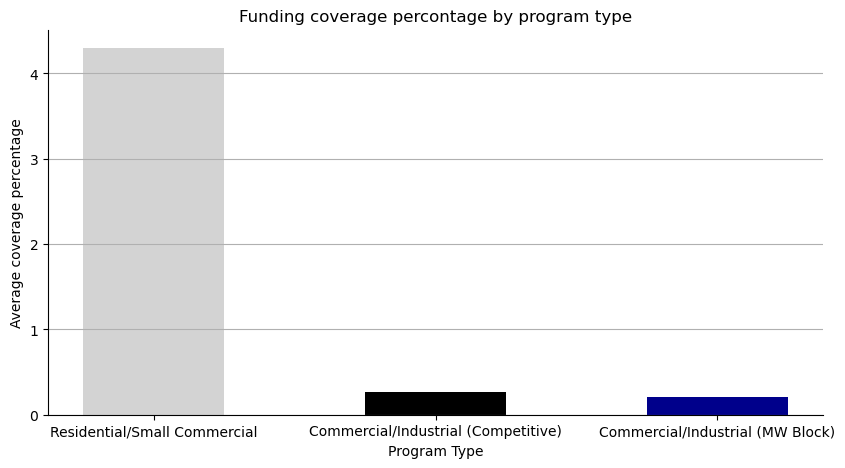

In [216]:
plt.figure(figsize=(10, 5)) 

plt.bar(x=['Residential/Small Commercial', 'Commercial/Industrial (Competitive)', 'Commercial/Industrial (MW Block)'],
        height=[resi_, compe_, commer_], width = .5, color = ['lightgrey', 'black', 'darkblue'])

plt.title("Funding coverage percontage by program type")
plt.xlabel("Program Type")
plt.ylabel("Average coverage percentage")

plt.grid(axis='y')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [224]:
data['coverage by funding'].loc[data['Program Type'] == 'Residential/Small Commercial'].describe()

count    151796.000000
mean          4.297510
std         429.010425
min           0.000000
25%           0.050033
50%           0.083333
75%           0.132408
max       77265.000000
Name: coverage by funding, dtype: float64

In [227]:
data.loc[(data['Program Type'] == 'Residential/Small Commercial') & (data['coverage by funding'] >= 1)]

,County,NYS Disadvantaged Community Status,Climate and Economic Justice Screening Tool Status,Program Type,Solicitation,Electric Utility,Purchase Type,Minority or Women Owned Business Enterprise (MWBE),Project Cost,Total NYSERDA Incentive,...,Total Nameplate kW DC,Expected KWh Annual Production,Community Distributed Generation,Green Jobs Green New York Participant,Application Year,Additional,cost after additional,cost after funding,coverage by additional,coverage by funding
9840,Albany,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,150.00,560.00,...,1.40,1493.0,No,No,2017,0.0,150.00,-410.00,0.0,3.733333
11865,Broome,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Purchase,No,150.00,2016.00,...,5.04,5884.0,No,No,2016,0.0,150.00,-1866.00,0.0,13.440000
18506,Cortland,Inside a NYS DAC,Inside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,150.00,2688.00,...,6.72,7508.0,No,No,2017,0.0,150.00,-2538.00,0.0,17.920000
23349,Franklin,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,176.00,705.00,...,3.66,2487.0,No,No,2019,0.0,176.00,-529.00,0.0,4.005682
28855,Kings,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,Consolidated Edison,Purchase,No,40.00,1090.00,...,5.45,7169.0,No,No,2024,0.0,40.00,-1050.00,0.0,27.250000
29135,Erie,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,NYS Electric and Gas,Purchase,No,30.00,3294.00,...,16.47,8448.0,No,No,2023,0.0,30.00,-3264.00,0.0,109.800000
31548,Herkimer,Outside a NYS DAC,Inside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,250.00,2464.00,...,7.04,7447.0,No,No,2018,0.0,250.00,-2214.00,0.0,9.856000
37046,Madison,Outside a NYS DAC,Inside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,320.00,3920.00,...,9.80,10780.0,No,No,2017,0.0,320.00,-3600.00,0.0,12.250000
41244,Madison,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,PON 2112,National Grid,Purchase,No,200.00,5513.00,...,15.75,17755.0,No,No,2017,0.0,200.00,-5313.00,0.0,27.565000
47658,Nassau,Outside a NYS DAC,Outside a CEJST DAC,Residential/Small Commercial,Solar Pioneer 2014,Long Island Power Authority,Purchase,No,2950.00,4158.17,...,8.58,10072.0,No,No,2014,0.0,2950.00,-1208.17,0.0,1.409549


In [232]:
resi2 = sum(data['coverage by funding'].loc[(data['Program Type'] == 'Residential/Small Commercial') & (data['coverage by funding'] <= 1)])/len((data['coverage by funding'].loc[(data['Program Type'] == 'Residential/Small Commercial') & (data['coverage by funding'] <= 1)]))
compe2 = sum(data['coverage by funding'].loc[(data['Program Type'] == 'Commercial/Industrial (Competitive)') & (data['coverage by funding'] <= 1)])/len(data['coverage by funding'].loc[(data['Program Type'] == 'Commercial/Industrial (Competitive)') & (data['coverage by funding'] <= 1)])
commer2 = sum(data['coverage by funding'].loc[(data['Program Type'] == 'Commercial/Industrial (MW Block)') & (data['coverage by funding'] <= 1)])/len(data['coverage by funding'].loc[(data['Program Type'] == 'Commercial/Industrial (MW Block)') & (data['coverage by funding'] <= 1)])

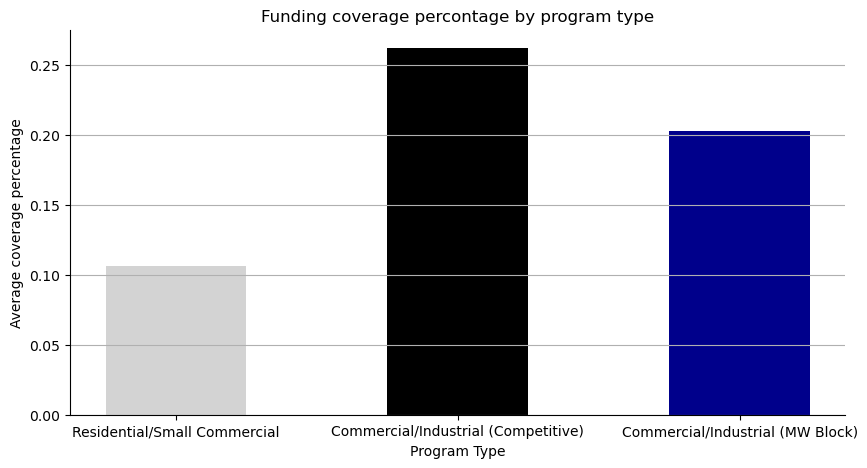

In [233]:
plt.figure(figsize=(10, 5)) 

plt.bar(x=['Residential/Small Commercial', 'Commercial/Industrial (Competitive)', 'Commercial/Industrial (MW Block)'],
        height=[resi2, compe2, commer2], width = .5, color = ['lightgrey', 'black', 'darkblue'])

plt.title("Funding coverage percontage by program type")
plt.xlabel("Program Type")
plt.ylabel("Average coverage percentage")

plt.grid(axis='y')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()